# Fake News Classifier IT

## Import

In [1]:
import re
import time
import joblib

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.DataFrame()
df = df.append(pd.read_csv('italian_dataset/Fake/6viola.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/databaseitalia.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/grandeinganno.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/ilfastidioso.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/ilgiornaledellasera.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/ilsapereepotere2.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/lacrunadellago.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/maurizioblondet.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/movimento3v.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/notiziedalmondooggi.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/reietto.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/thedayafter2012.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/terrarealtime.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/totalitarismo-blog.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/usciredallorrore.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/verita-globale.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/Fake/video-reporter.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/True/quotidianomolise.csv', index_col=0))
df = df.append(pd.read_csv('italian_dataset/True/ilfattoquotidiano.csv', index_col=0))
df.head()

link  \
0  https://6viola.wordpress.com/2022/01/23/malore...   
1  https://6viola.wordpress.com/2022/01/23/nuovi-...   
2  https://6viola.wordpress.com/2022/01/17/cosa-c...   
3  https://6viola.wordpress.com/2022/01/17/il-cam...   
4  https://6viola.wordpress.com/2022/01/17/tar-de...   

                                               title  \
0  Malore improvviso a scuola, Giada è morta a 14...   
1  Nuovi studi sul contenuto dei finti vax, che s...   
2  COSA C’É NEL VACCINO? É TEMPO DI VERIFICHE, É ...   
3  Il cambio della “narrativa” sul covid19 sbarca...   
4         Tar del Lazio sulle terapie domiciliari ..   

                                                text label  
0  Giada, 14 anni, è morta in ospedale dopo un ma...  Fake  
1  Ogni dose ha ingredienti diversi secondo un ri...  Fake  
2                                                NaN  Fake  
3                                                NaN  Fake  
4  Il TAR accoglie il ricorso del “Comitato cura ...  Fake

In [3]:
df.shape

(27353, 4)

## Imputation

In [4]:
df = df.dropna()
df.shape

(26150, 4)

## Visualization

(array([15950.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10200.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

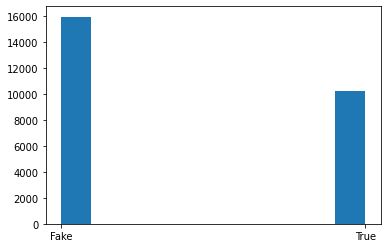

In [5]:
df['label'] = [str(label) for label in df['label']]
plt.hist(df['label'])

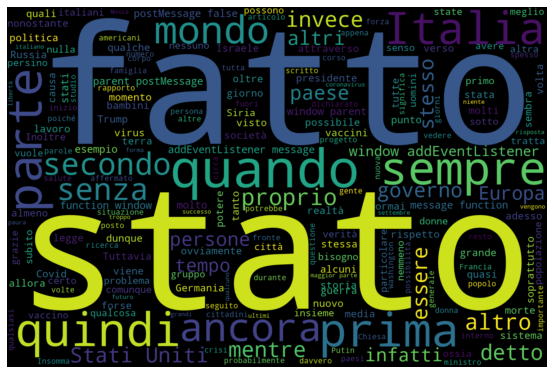

In [6]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, stopwords=stopwords.words("italian"), background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing


In [7]:
print("Title:\n", df['title'].values[0])
print("Body:\n", df['text'].values[0])

Title:
 Malore improvviso a scuola, Giada è morta a 14 anni: si è spenta in ospedale (6 dicembre 2021)
Body:
 Giada, 14 anni, è morta in ospedale dopo un malore improvviso accusato a scuola. La notizia ha mandato sotto choc la famiglia e l’intera comunità. Giada era giovanissima e la sua morte, così improvvisa, ha letteralmente spiazzato i suoi familiari e chi la conosceva. Una perdita veramente tragica, difficile da sopportare. (Continua dopo la foto…)


### Remove junk

In [8]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

link  \
0  https://6viola.wordpress.com/2022/01/23/malore...   
1  https://6viola.wordpress.com/2022/01/23/nuovi-...   
4  https://6viola.wordpress.com/2022/01/17/tar-de...   
8  https://6viola.wordpress.com/2022/01/15/ennesi...   
9  https://6viola.wordpress.com/2022/01/15/deside...   

                                               title  \
0  malore improvviso a scuola giada morta a anni ...   
1  nuovi studi sul contenuto dei finti vax che so...   
4           tar del lazio sulle terapie domiciliari    
8  ennesima follia sanitario guarito non pu torna...   
9  desidero vaccinarmi qui ed ora ma non mi viene...   

                                                text label  
0  giada anni morta in ospedale dopo un malore im...  Fake  
1  ogni dose ha ingredienti diversi secondo un ri...  Fake  
4  il tar accoglie il ricorso del comitato cura d...  Fake  
8  di andrea brancolini una volont di ledere non ...  Fake  
9  una donna ultracinquantenne obbligata a vaccin...  Fake

In [9]:
print("Title:\n", df['title'].values[0])
print("Body:\n", df['text'].values[0])

Title:
 malore improvviso a scuola giada morta a anni si spenta in ospedale dicembre 
Body:
 giada anni morta in ospedale dopo un malore improvviso accusato a scuola la notizia ha mandato sotto choc la famiglia e l intera comunit giada era giovanissima e la sua morte cos improvvisa ha letteralmente spiazzato i suoi familiari e chi la conosceva una perdita veramente tragica difficile da sopportare continua dopo la foto 


### Remove stop words

In [10]:
stop_words = set(stopwords.words("italian"))

def remove_stop_words(text):
  res = []
  for word in text.split():
      if word not in stop_words:
          res.append(word)
  return " ".join(res)

df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

link  \
0  https://6viola.wordpress.com/2022/01/23/malore...   
1  https://6viola.wordpress.com/2022/01/23/nuovi-...   
4  https://6viola.wordpress.com/2022/01/17/tar-de...   
8  https://6viola.wordpress.com/2022/01/15/ennesi...   
9  https://6viola.wordpress.com/2022/01/15/deside...   

                                               title  \
0  malore improvviso scuola giada morta anni spen...   
1  nuovi studi contenuto finti vax realt farmaci ...   
4                      tar lazio terapie domiciliari   
8  ennesima follia sanitario guarito pu tornare l...   
9  desidero vaccinarmi qui ora viene effettuata v...   

                                                text label  
0  giada anni morta ospedale dopo malore improvvi...  Fake  
1  ogni dose ingredienti diversi secondo ricercat...  Fake  
4  tar accoglie ricorso comitato cura domiciliare...  Fake  
8  andrea brancolini volont ledere pu interpretar...  Fake  
9  donna ultracinquantenne obbligata vaccinarsi s...  Fake

In [11]:
print("Title:\n", df['title'].values[0])
print("Body:\n", df['text'].values[0])

Title:
 malore improvviso scuola giada morta anni spenta ospedale dicembre
Body:
 giada anni morta ospedale dopo malore improvviso accusato scuola notizia mandato sotto choc famiglia intera comunit giada giovanissima morte cos improvvisa letteralmente spiazzato familiari conosceva perdita veramente tragica difficile sopportare continua dopo foto


### Stemming

In [12]:
port = SnowballStemmer(language='italian')

def stemmer(text):
  res = []
  for word in text.split():
      res.append(port.stem(word))
  return " ".join(res)

df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

link  \
0  https://6viola.wordpress.com/2022/01/23/malore...   
1  https://6viola.wordpress.com/2022/01/23/nuovi-...   
4  https://6viola.wordpress.com/2022/01/17/tar-de...   
8  https://6viola.wordpress.com/2022/01/15/ennesi...   
9  https://6viola.wordpress.com/2022/01/15/deside...   

                                               title  \
0  malor improvvis scuol giad mort anni spent osp...   
1  nuov stud conten fint vax realt farmac sperime...   
4                           tar laz terap domiciliar   
8     ennesim foll sanitar guar pu torn lavor vaccin   
9  desider vaccin qui ora vien effettu vaccin per...   

                                                text label  
0  giad anni mort ospedal dop malor improvvis acc...  Fake  
1  ogni dos ingredient div second ricerc canades ...  Fake  
4  tar accogl ricors comit cur domicil covid sosp...  Fake  
8  andre brancolin volont led pu interpret altrim...  Fake  
9  donn ultracinquantenn obblig vaccin second rec...  Fake

In [13]:
print("Title:\n", df['title'].values[0])
print("Body:\n", df['text'].values[0])

Title:
 malor improvvis scuol giad mort anni spent ospedal dicembr
Body:
 giad anni mort ospedal dop malor improvvis accus scuol notiz mand sott choc famigl inter comunit giad giovanissim mort cos improvvis letteral spiazz familiar conosc perd ver tragic difficil sopport continu dop fot


## ML Model

In [14]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [15]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1,2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
models = list()
for classifier in classifiers:
    start_time = time.time()

    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    training_time = time.time() - start_time
    print_metrics(y_test, y_pred, training_time)
    models.append(model)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 22 s
1. Accuracy: 0.9018
2. Precision: 0.9127
3. Recall: 0.8849
4. F1 score: 0.8946
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       4564   143
True        627  2511
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 15 s
1. Accuracy: 0.9383
2. Precision: 0.9402
3. Recall: 0.9311
4. F1 score: 0.9351
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       4552   155
True        329  2809
---------------------------------
DecisionTreeClassifier()


0. Training time: 64 s
1. Accuracy: 0.8534
2. Precision: 0.8481
3. Recall: 0.8456
4. F1 score: 0.8468
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       4164   543
True        607  2531
---------------------------------
AdaBoostClassifier()


0. Training time: 47 s
1. Accuracy: 0.8911
2. Precision: 0.8916
3. Recall: 0.8804
4. F1 score: 0.8851
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       4397   310
True        544  2594
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 15 s
1. Accuracy: 0.8962
2. Precision: 0.9114
3. Recall: 0.8764
4. F1 score: 0.8878
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       4592   115
True        699  2439


In [17]:
joblib.dump(models[0], open('italian_models/random_forest.joblib', 'wb'))
joblib.dump(models[1], open('italian_models/logistic_regression.joblib', 'wb'))
joblib.dump(models[2], open('italian_models/decision_tree.joblib', 'wb'))
joblib.dump(models[3], open('italian_models/ada_boost.joblib', 'wb'))
joblib.dump(models[4], open('italian_models/knn.joblib', 'wb'))